In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from attack_utils import *

In [2]:
all_likelihoods = torch.load("70m_0.005_15.pt")
train_likelihoods = all_likelihoods[:all_likelihoods.shape[0]//2,]
valid_likelihoods = all_likelihoods[all_likelihoods.shape[0]//2:,]

In [3]:
train_mope = -(train_likelihoods[1:,:].mean(dim=0) - train_likelihoods[0,:])
valid_mope = -(valid_likelihoods[1:,:].mean(dim=0) - valid_likelihoods[0,:])

mope_z_scores = stats.zscore(torch.concat((train_mope, valid_mope)))
train_mope_z = mope_z_scores[:len(mope_z_scores)//2] + min(mope_z_scores)
valid_mope_z = mope_z_scores[len(mope_z_scores)//2:] + min(mope_z_scores)

loss_z_scores = stats.zscore(torch.concat((train_likelihoods[0,:], valid_likelihoods[0,:])))
train_loss_z  = loss_z_scores[:len(loss_z_scores)//2] + min(loss_z_scores)
valid_loss_z  = loss_z_scores[len(loss_z_scores)//2:] + min(loss_z_scores)

/Users/marvinli/opt/anaconda3/envs/in-context-learning/lib/python3.8/site-packages/scipy/stats/_stats_py.py:2883: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646755922314/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  z[np.broadcast_to(isconst, z.shape)] = np.nan


/Users/marvinli/Documents/unlearning-large/attack_utils.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_statistic = torch.tensor(train_statistic).flatten()
/Users/marvinli/Documents/unlearning-large/attack_utils.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_statistic = torch.tensor(val_statistic).flatten()


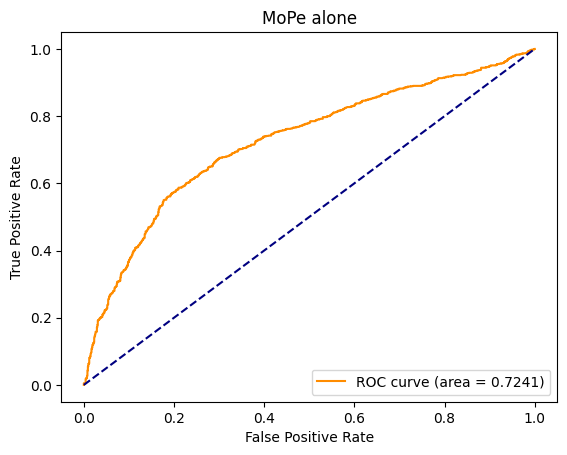

In [4]:
 plot_ROC(train_mope_z, valid_mope_z, title="MoPe alone")

/Users/marvinli/Documents/unlearning-large/attack_utils.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_statistic = torch.tensor(train_statistic).flatten()
/Users/marvinli/Documents/unlearning-large/attack_utils.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_statistic = torch.tensor(val_statistic).flatten()


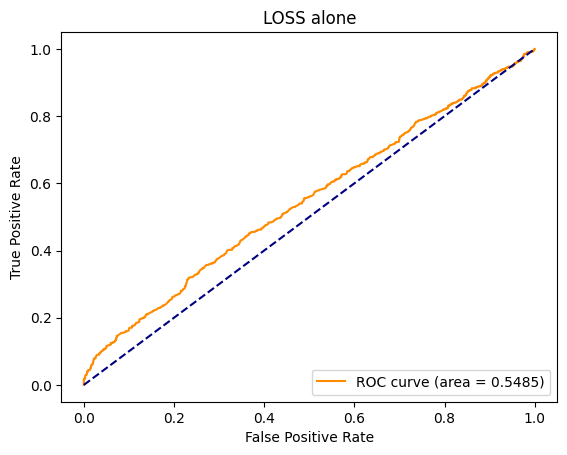

In [5]:
 plot_ROC(train_loss_z, valid_loss_z, title="LOSS alone")

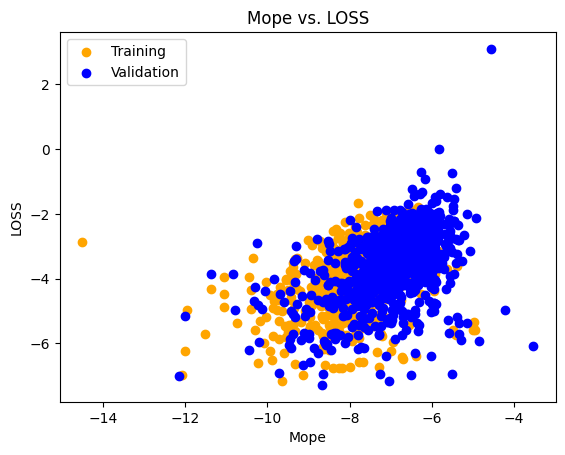

In [6]:
# Create the scatter plot
plt.scatter(train_mope_z, train_loss_z, c='orange', label='Training')
plt.scatter(valid_mope_z, valid_loss_z, c='blue', label='Validation')

# Set labels and title
plt.xlabel('Mope')
plt.ylabel('LOSS')
plt.title('Mope vs. LOSS')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [7]:
#Scale mope and loss to be between [0,1] to be a fair comparison

scaled_train_mope_z = (train_mope_z-min(mope_z_scores))/(max(mope_z_scores)-min(mope_z_scores))
scaled_valid_mope_z = (valid_mope_z-min(mope_z_scores))/(max(mope_z_scores)-min(mope_z_scores))

scaled_train_loss_z = (train_loss_z-min(loss_z_scores))/(max(loss_z_scores)-min(loss_z_scores))
scaled_valid_loss_z = (valid_loss_z-min(loss_z_scores))/(max(loss_z_scores)-min(loss_z_scores))

In [8]:
def find_best_lambda(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, stepsize = 0.01):
    best_lmbda = -1
    best_auc   = 0
    for lmbda in np.arange(0,1,stepsize):
        train_mix = train_mope_z * lmbda + (1-lmbda) * train_loss_z 
        valid_mix = valid_mope_z * lmbda + (1-lmbda) * valid_loss_z 
        fpr, tpr, _ = roc_curve(np.concatenate((np.zeros_like(train_mix),np.ones_like(valid_mix))),
                                np.concatenate((train_mix, valid_mix)))
        if best_auc < auc(fpr, tpr):
            best_auc = auc(fpr, tpr)
            best_lmbda = lmbda
    print(best_auc)
    return best_lmbda, train_mope_z * best_lmbda + (1-best_lmbda) * train_loss_z , valid_mope_z * best_lmbda + (1-best_lmbda) * valid_loss_z 

In [9]:
best_lmbda, train_stat, valid_stat = find_best_lambda(scaled_train_mope_z, scaled_valid_mope_z, scaled_train_loss_z, scaled_valid_loss_z)

0.7233885


/Users/marvinli/Documents/unlearning-large/attack_utils.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_statistic = torch.tensor(train_statistic).flatten()
/Users/marvinli/Documents/unlearning-large/attack_utils.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_statistic = torch.tensor(val_statistic).flatten()


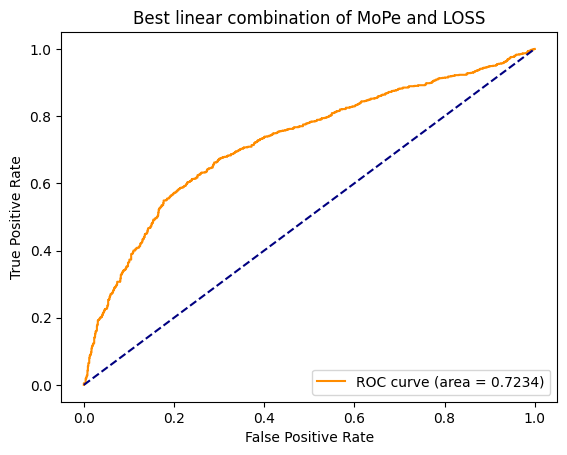

In [10]:
plot_ROC(train_stat, valid_stat, "Best linear combination of MoPe and LOSS")

In [11]:
def compute_fpr_tpr_or(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, rat=1):
    from sklearn.metrics import confusion_matrix
    
    thresholds = np.sort(np.concatenate((train_mope_z, valid_mope_z, train_loss_z, valid_loss_z)))
    fpr = []
    tpr = []
    for t in thresholds:
        train_pred = np.logical_or(train_mope_z < t*rat, train_loss_z < t)
        valid_pred = np.logical_or(valid_mope_z < t*rat, valid_loss_z < t)
        y_pred = np.concatenate((train_pred, valid_pred))
        y_real = np.concatenate((np.ones_like(train_mope_z), np.zeros_like(valid_mope_z)))
    
        tn, fp, fn, tp = confusion_matrix(y_real, y_pred).ravel()
        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
    return np.array(fpr), np.array(tpr)

def compute_fpr_tpr_and(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, rat=1):
    from sklearn.metrics import confusion_matrix
    
    thresholds = np.sort(np.concatenate((train_mope_z, valid_mope_z, train_loss_z, valid_loss_z)))
    fpr = []
    tpr = []
    for t in thresholds:
        train_pred = np.logical_and(train_mope_z < t*rat, train_loss_z < t)
        valid_pred = np.logical_and(valid_mope_z < t*rat, valid_loss_z < t)
        y_pred = np.concatenate((train_pred, valid_pred))
        y_real = np.concatenate((np.ones_like(train_mope_z), np.zeros_like(valid_mope_z)))
    
        tn, fp, fn, tp = confusion_matrix(y_real, y_pred).ravel()
        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
    return np.array(fpr), np.array(tpr)

In [12]:
def find_best_or(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, start= 0.01, end = 3):
    best_auc = 0
    best_fpr, best_tpr = None, None
    best_m = None
    for m in np.arange(start,end,0.1):
        fpr, tpr = compute_fpr_tpr_or(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, rat=m)
        roc_auc  = auc(fpr, tpr)
        if roc_auc > best_auc:
            best_m = m
            best_auc = roc_auc 
            best_fpr, best_tpr = fpr, tpr
    return best_m, best_auc, best_fpr, best_tpr

def find_best_and(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, start= 0.01, end = 3):
    best_auc = 0
    best_fpr, best_tpr = None, None
    best_m = None
    for m in np.arange(start,end,0.1):
        fpr, tpr = compute_fpr_tpr_and(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, rat=m)
        roc_auc  = auc(fpr, tpr)
        if roc_auc > best_auc:
            best_m = m
            best_auc = roc_auc 
            best_fpr, best_tpr = fpr, tpr
    return best_m, best_auc, best_fpr, best_tpr

0.31000000000000005


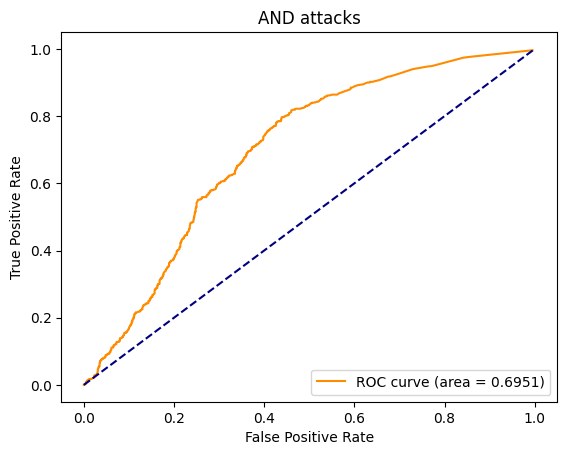

In [13]:
best_and_m, roc_auc, fpr, tpr = find_best_and(scaled_train_mope_z, scaled_valid_mope_z, scaled_train_loss_z, scaled_valid_loss_z)

print(best_and_m)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("AND attacks")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

0.21000000000000002


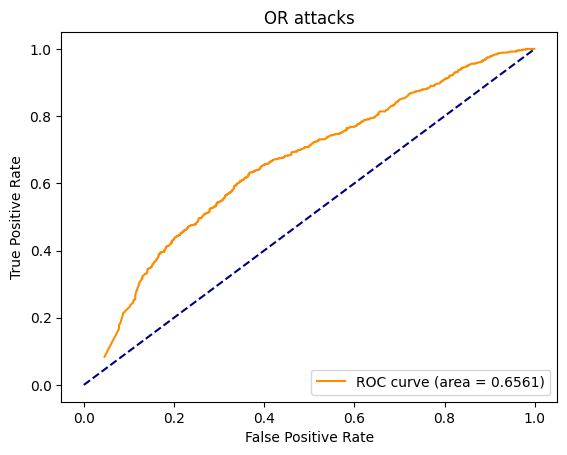

In [14]:
best_or_m, roc_auc, fpr, tpr = find_best_or(scaled_train_mope_z, scaled_valid_mope_z, scaled_train_loss_z, scaled_valid_loss_z)
print(best_or_m)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("OR attacks")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()